#### Config

In [7]:
import torch
from matplotlib.ticker import PercentFormatter, MaxNLocator
from checkpoint import model_from_checkpoint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from matplotlib.colors import LinearSegmentedColormap

_colors = ["#0d0887", "#7e03a8", "#cc4678", "#f89441", "#f0f921"]
my_cmap = LinearSegmentedColormap.from_list("mycmap", _colors, N=256)

#### Heatmap Helpers

##### Ungrouped

In [8]:

def plot_param_heatmaps(model, cols=6, cmap_count=my_cmap, cmap_bytes=my_cmap):
    items = []
    for name, t in model.state_dict().items():
        n = t.numel()
        nb = n * t.element_size()
        items.append((name, n, nb))

    # Sort consistently to keep positions aligned across both maps
    items.sort(key=lambda x: x[1], reverse=True)
    names = [x[0] for x in items]
    counts = np.array([x[1] for x in items], dtype=float)
    bytes_ = np.array([x[2] for x in items], dtype=float)

    total_counts = counts.sum() if counts.sum() > 0 else 1.0
    total_bytes = bytes_.sum() if bytes_.sum() > 0 else 1.0
    frac_counts = counts / total_counts
    frac_bytes = bytes_ / total_bytes

    n = len(items)
    rows = int(np.ceil(n / cols))
    size = rows * cols

    grid_counts = np.zeros(size, dtype=float)
    grid_bytes = np.zeros(size, dtype=float)
    grid_counts[:n] = frac_counts
    grid_bytes[:n] = frac_bytes
    grid_counts = grid_counts.reshape(rows, cols)
    grid_bytes = grid_bytes.reshape(rows, cols)

    fig, axes = plt.subplots(1, 2, figsize=(cols*1.4*2, max(1.6, rows*1.4)))
    # by count
    im1 = axes[0].imshow(grid_counts, cmap=cmap_count, aspect="auto")
    cbar1 = fig.colorbar(im1, ax=axes[0], label="Share of total params")
    cbar1.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))  # 0–100%
    cbar1.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max1 = grid_counts.max() if grid_counts.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < n:
                label = f"{names[idx]}\n{frac_counts[idx]*100:.1f}%"
                color = "white" if grid_counts[i, j] > (max1/3 if max1 else 0) else "black"
                axes[0].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_title("Parameter distribution (count)")

    # norm = colors.Normalize(vmin=0, vmax=0.2)
    #  gamma-like emphasis
    norm = colors.PowerNorm(gamma=0.5)                  # brighten small values
    # percentile-based clipping
    def pct_norm(a, lo=2, hi=98):
        vmin, vmax = np.percentile(a[a>0], [lo, hi]) if (a>0).any() else (0, 1)
        return colors.Normalize(vmin=vmin, vmax=vmax)

    # im = axes[0].imshow(grid_counts, cmap=cmap_count, norm=norm, aspect="auto")

    # by bytes
    im2 = axes[1].imshow(grid_bytes, cmap=cmap_bytes, aspect="auto", norm=norm)
    cbar2 = fig.colorbar(im2, ax=axes[1], label="Share of total bytes")
    cbar2.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar2.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))
    max2 = grid_bytes.max() if grid_bytes.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < n:
                label = f"{names[idx].split('.')[-1]}\n{frac_bytes[idx]*100:.1f}%"
                color = "white" if grid_bytes[i, j] > (max2/3 if max2 else 0) else "black"
                axes[1].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[1].set_xticks([]); axes[1].set_yticks([])
    axes[1].set_title(f"Parameter distribution (bytes) ~ {total_bytes/1e6:.1f} MB")

    plt.tight_layout()
    plt.show()


##### Grouped

In [9]:
import re
from collections import defaultdict


def group_params_by_suffix(state_dict):
    pat = re.compile(r"^(?:blocks|value_embeds)\.(\d+)\.(.+)$")
    grouped = defaultdict(list)
    counts = defaultdict(int)
    bytes_ = defaultdict(int)

    for name, t in state_dict.items():
        m = pat.match(name)
        d_name = None
        if m:
            d_name = m.group(0)
            suffix = m.group(2)
            key = "value_embeds" if "value_embeds" in name else suffix
        else:
            key = name

        grouped[key].append((d_name , t))
        counts[key] += t.numel()
        bytes_[key] += t.numel() * t.element_size()

    return dict(grouped), dict(counts), dict(bytes_)

def plot_param_heatmaps_grouped(model, cols=6, cmap_count="viridis", cmap_bytes="magma"):
    grouped, counts_map, bytes_map = group_params_by_suffix(model.state_dict())

    # build items from grouped aggregates
    names = list(counts_map.keys())
    counts = np.array([counts_map[k] for k in names], dtype=float)
    bytes_ = np.array([bytes_map[k] for k in names], dtype=float)

    # sort by size to stabilize layout
    order = np.argsort(-counts)
    names = [names[i] for i in order]
    counts = counts[order]
    bytes_ = bytes_[order]

    total_counts = counts.sum() if counts.sum() > 0 else 1.0
    total_bytes = bytes_.sum() if bytes_.sum() > 0 else 1.0
    frac_counts = counts / total_counts
    frac_bytes = bytes_ / total_bytes

    n = len(names)
    rows = int(np.ceil(n / cols))
    size = rows * cols

    grid_counts = np.zeros(size, dtype=float)
    grid_bytes = np.zeros(size, dtype=float)
    grid_counts[:n] = frac_counts
    grid_bytes[:n] = frac_bytes
    grid_counts = grid_counts.reshape(rows, cols)
    grid_bytes = grid_bytes.reshape(rows, cols)

    fig, axes = plt.subplots(1, 2, figsize=(cols * 1.4 * 2, max(1.6, rows * 1.4)))
    im1 = axes[0].imshow(grid_counts, cmap=cmap_count, aspect="auto")
    cbar1 = fig.colorbar(im1, ax=axes[0], label="Share of total params")
    cbar1.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar1.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max1 = grid_counts.max() if grid_counts.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < n:
                label = f"{names[idx]}\n{frac_counts[idx] * 100:.1f}%"
                color = "white" if grid_counts[i, j] > (max1 / 3 if max1 else 0) else "black"
                axes[0].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Grouped parameter distribution (count)")

    from matplotlib import colors
    norm = colors.PowerNorm(gamma=0.5)
    im2 = axes[1].imshow(grid_bytes, cmap=cmap_bytes, aspect="auto", norm=norm)
    cbar2 = fig.colorbar(im2, ax=axes[1], label="Share of total bytes")
    cbar2.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar2.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max2 = grid_bytes.max() if grid_bytes.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < n:
                # shorten label by showing last 2 components when long
                parts = names[idx].split(".")
                short = ".".join(parts[-2:]) if len(parts) > 2 else names[idx]
                label = f"{short}\n{frac_bytes[idx] * 100:.1f}%"
                color = "white" if grid_bytes[i, j] > (max2 / 3 if max2 else 0) else "black"
                axes[1].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[1].set_xticks([]);
    axes[1].set_yticks([])
    axes[1].set_title(f"Grouped parameter distribution (bytes) ~ {total_bytes / 1e6:.1f} MB")

    plt.tight_layout()
    plt.show()


### Stats

In [10]:
from checkpoint import model_from_checkpoint

model, _ = model_from_checkpoint("/Users/jonathanmiddleton/projects/daisy-wee/checkpoints/20251103T0243-val5.810-step000600-run0-best.pt", device='mps')
model.eval()
total_params = sum(p.numel() for p in model.parameters())
for p in model.state_dict().items():
    print(f"[name] {p[0]},\t\t [shape] {list(p[1].shape)},\t [dtype] {str(p[1].dtype)[6:]},\t [numel] {p[1].numel()},\t [%total] {p[1].numel()/total_params*100:.2f}%")


[name] lm_head_w,		 [shape] [50304, 512],	 [dtype] float32,	 [numel] 25755648,	 [%total] 17.45%
[name] scalars,		 [shape] [30],	 [dtype] float32,	 [numel] 30,	 [%total] 0.00%
[name] embed.weight,		 [shape] [50257, 512],	 [dtype] float32,	 [numel] 25731584,	 [%total] 17.44%
[name] value_embeds.0.weight,		 [shape] [50257, 512],	 [dtype] float32,	 [numel] 25731584,	 [%total] 17.44%
[name] value_embeds.1.weight,		 [shape] [50257, 512],	 [dtype] float32,	 [numel] 25731584,	 [%total] 17.44%
[name] value_embeds.2.weight,		 [shape] [50257, 512],	 [dtype] float32,	 [numel] 25731584,	 [%total] 17.44%
[name] blocks.0.attn.qkvo_w,		 [shape] [4, 512, 512],	 [dtype] bfloat16,	 [numel] 1048576,	 [%total] 0.71%
[name] blocks.0.mlp.fc_w,		 [shape] [2048, 512],	 [dtype] bfloat16,	 [numel] 1048576,	 [%total] 0.71%
[name] blocks.0.mlp.proj_w,		 [shape] [512, 2048],	 [dtype] bfloat16,	 [numel] 1048576,	 [%total] 0.71%
[name] blocks.1.attn.qkvo_w,		 [shape] [4, 512, 512],	 [dtype] bfloat16,	 [numel] 1048576

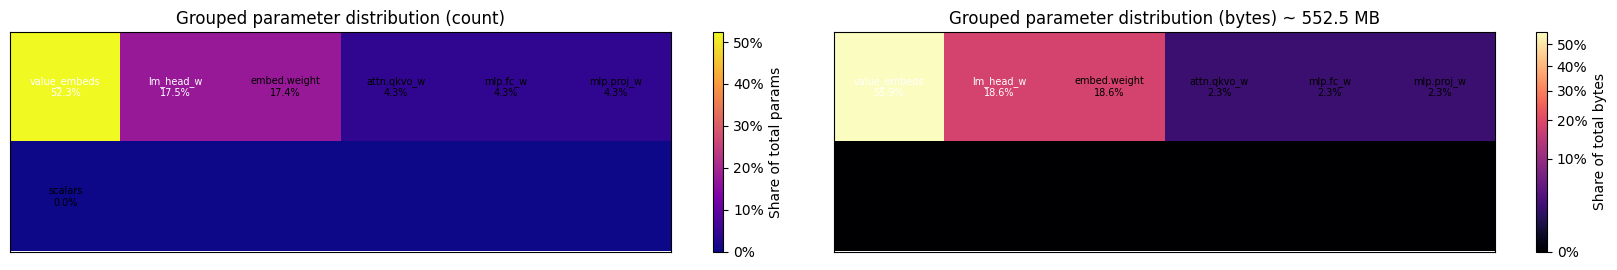

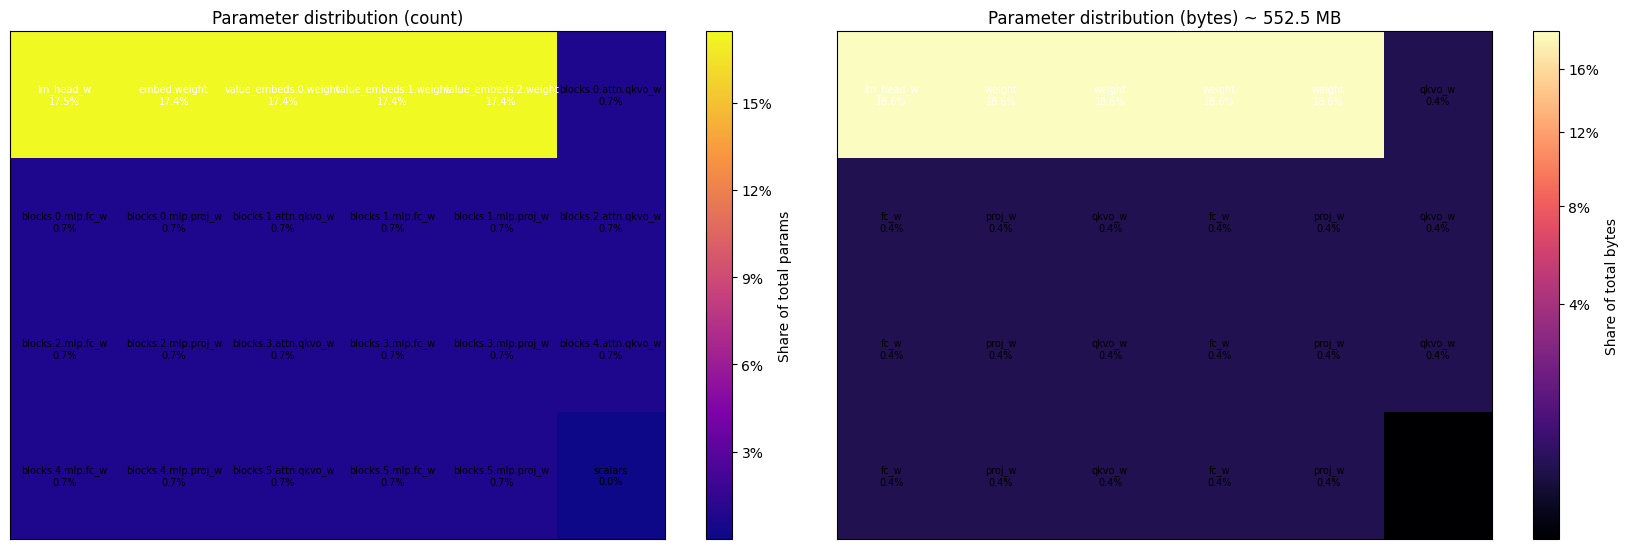

In [11]:
plot_param_heatmaps_grouped(model, cmap_count=my_cmap, cmap_bytes="magma")

plot_param_heatmaps(model, cmap_count=my_cmap, cmap_bytes="magma")